## Causal impact failure modes (and how to detect them)

This notebook is designed as a trustworthiness guide for time-series causal impact evaluation.

We demonstrate common failure modes:

- Weak covariates - poor pre-fit, unreliable counterfactual.
- Confounding covariates (covariates shift at intervention) - spurious effects.
- Short pre-period - unstable estimates and wide uncertainty.
  
We use synthetic data so we can compare the true effect vs the estimated effect.

In [2]:
import sys
from pathlib import Path

repo_root = Path.cwd()
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tecore.causal import DataSpec, ImpactConfig, ImpactMethod, run_impact
from tecore.causal.simulate_ts import SyntheticTSConfig, generate_synthetic_time_series

## Helper utilities

In [3]:
import matplotlib.dates as mdates

def _resolve_cols(d: pd.DataFrame):
    effect_col = "effect" if "effect" in d.columns else "point_effect"

    ci_pairs = [
        ("effect_lower", "effect_upper"),
        ("point_ci_low", "point_ci_high"),
        ("ci_low", "ci_high"),
        ("lower", "upper"),
    ]
    lo_col = hi_col = None
    for a, b in ci_pairs:
        if a in d.columns and b in d.columns:
            lo_col, hi_col = a, b
            break

    cum_pairs = [
        ("cum_lower", "cum_upper"),
        ("cum_ci_low", "cum_ci_high"),
    ]
    cum_lo = cum_hi = None
    for a, b in cum_pairs:
        if a in d.columns and b in d.columns:
            cum_lo, cum_hi = a, b
            break

    return effect_col, lo_col, hi_col, cum_lo, cum_hi

def _format_dates(ax):
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

def plot_observed_vs_counterfactual(effect_df, intervention_date, title):
    d = effect_df.copy()
    d["date"] = pd.to_datetime(d["date"])

    plt.figure(figsize=(11, 4))
    plt.plot(d["date"], d["y"], label="observed", linewidth=2)
    plt.plot(d["date"], d["y_hat"], label="counterfactual", linewidth=2)
    plt.axvline(pd.Timestamp(intervention_date), linestyle="--")
    plt.title(title)
    plt.legend()
    _format_dates(plt.gca())
    plt.tight_layout()
    plt.show()

def plot_point_effect(effect_df, intervention_date, title):
    d = effect_df.copy()
    d["date"] = pd.to_datetime(d["date"])

    effect_col, lo_col, hi_col, _, _ = _resolve_cols(d)

    plt.figure(figsize=(11, 4))
    plt.plot(d["date"], d[effect_col], label=effect_col)
    if lo_col is not None:
        plt.fill_between(d["date"], d[lo_col], d[hi_col], alpha=0.2, label="CI")
    else:
        print("No point-effect CI columns found; plotting effect without CI.")
        print("Available columns:", d.columns.tolist())

    plt.axhline(0.0, linestyle="--")
    plt.axvline(pd.Timestamp(intervention_date), linestyle="--")
    plt.title(title)
    plt.legend()
    _format_dates(plt.gca())
    plt.tight_layout()
    plt.show()

def plot_cum_effect(effect_df, intervention_date, title):
    d = effect_df.copy()
    d["date"] = pd.to_datetime(d["date"])

    _, _, _, cum_lo, cum_hi = _resolve_cols(d)

    plt.figure(figsize=(11, 4))
    plt.plot(d["date"], d["cum_effect"], label="cum_effect")
    if cum_lo is not None:
        plt.fill_between(d["date"], d[cum_lo], d[cum_hi], alpha=0.2, label="CI")
    else:
        print("No cumulative CI columns found; plotting cum_effect without CI.")
        print("Available columns:", d.columns.tolist())

    plt.axhline(0.0, linestyle="--")
    plt.axvline(pd.Timestamp(intervention_date), linestyle="--")
    plt.title(title)
    plt.legend()
    _format_dates(plt.gca())
    plt.tight_layout()
    plt.show()

def run_ci(df, intervention_date, x_cols, bootstrap=200, block_size=7, ridge_alpha=1.0, run_placebo=True, n_placebos=25):
    spec = DataSpec(
        date_col="date",
        y_col="y",
        x_cols=x_cols,
        freq="D",
        missing_policy="raise",
        aggregation="mean",
        add_time_trend=True,
        add_day_of_week=True,
    )
    cfg = ImpactConfig(
        intervention_date=intervention_date,
        method=ImpactMethod.CAUSAL_IMPACT_LIKE,
        ridge_alpha=ridge_alpha,
        bootstrap_iters=bootstrap,
        block_size=block_size,
        alpha=0.05,
        run_placebo=run_placebo,
        n_placebos=n_placebos,
        pre_period_min_points=42,
    )
    return run_impact(df, spec, cfg)

## Scenario A: Healthy setup (strong controls, no confounding)

We generate a dataset with a real positive intervention effect and covariates that explain y well in the pre-period.

In [4]:
cfg_good = SyntheticTSConfig(
    n_days=220,
    start_date="2025-01-01",
    intervention_day=140,
    level_shift=12.0,
    slope_change=0.0,
    temp_effect_amp=6.0,
    temp_effect_decay=0.10,
    confounding=False,
    random_state=10,
)
df_good, meta_good = generate_synthetic_time_series(cfg_good)
meta_good

{'intervention_date': '2025-05-21',
 'true_cum_effect': 1023.028840752756,
 'true_avg_effect': 12.78786050940945}

In [5]:
res_good = run_ci(
    df_good,
    intervention_date=meta_good["intervention_date"],
    x_cols=["sessions", "active_users", "marketing_spend", "external_index"],
    bootstrap=250,
    run_placebo=True,
    n_placebos=30,
)
res_good.summary()

{'method': 'causal_impact_like',
 'intervention_date': '2025-05-21',
 'point_effect': 15.754925164653457,
 'point_ci': (14.970119096065996, 16.52550138287245),
 'cum_effect': 1260.3940131722766,
 'cum_ci': (1197.6095276852798, 1322.040110629796),
 'rel_effect': 0.08472228913319484,
 'rel_ci': (0.08050198557976852, 0.08886607150453746),
 'p_value': 0.0,
 'warnings': [],
 'diagnostics': {'r2_pre': 0.9608552444864409,
  'rmse_pre': 4.699210051940701,
  'acf_lag1': 0.04413520845664132,
  'acf_lag2': -0.09422023095904274,
  'acf_lag3': -0.14649324913302816,
  'acf_lag4': -0.1496729017701559,
  'acf_lag5': -0.09250284173790432,
  'acf_lag6': 0.12253514399597334,
  'acf_lag7': 0.07383902336213824,
  'max_abs_acf_1_to_7': 0.1496729017701559},
 'economics': None}

In [7]:
print("True cumulative effect (synthetic):", meta_good.get("true_cum_effect"))
print("Estimated cumulative effect:", res_good.cum_effect)
print("CI:", res_good.cum_ci)
print("Placebo p-value:", res_good.p_value)

True cumulative effect (synthetic): 1023.028840752756
Estimated cumulative effect: 1260.3940131722766
CI: (1197.6095276852798, 1322.040110629796)
Placebo p-value: 0.0


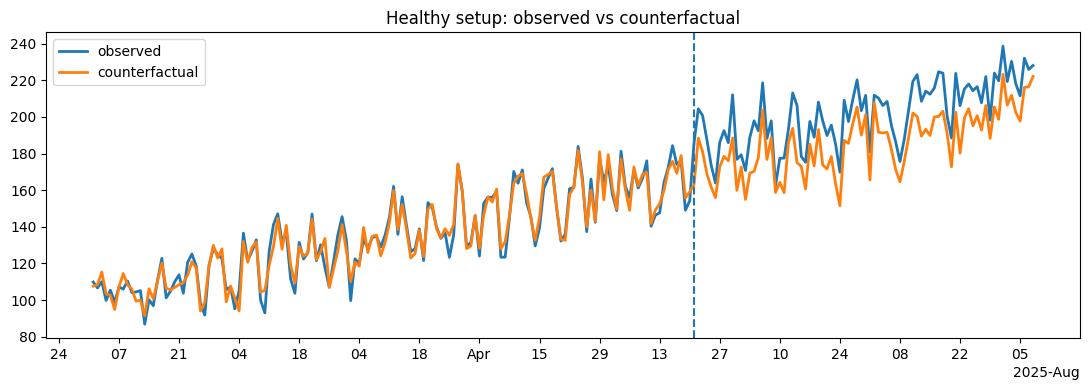

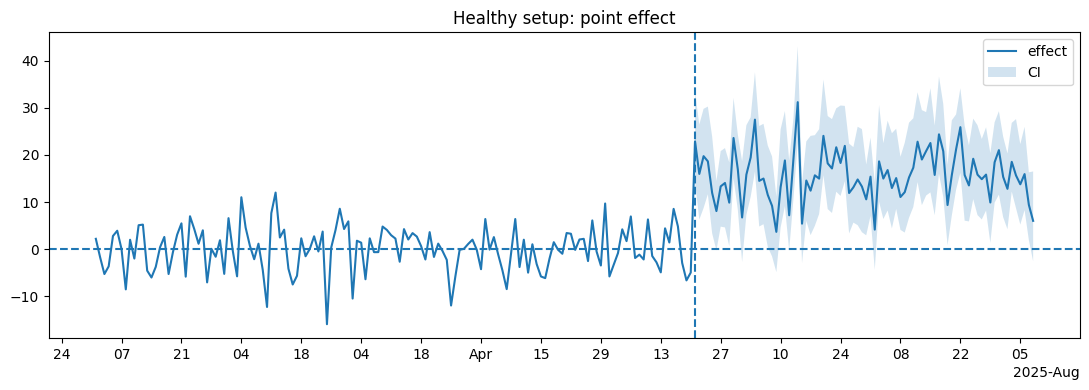

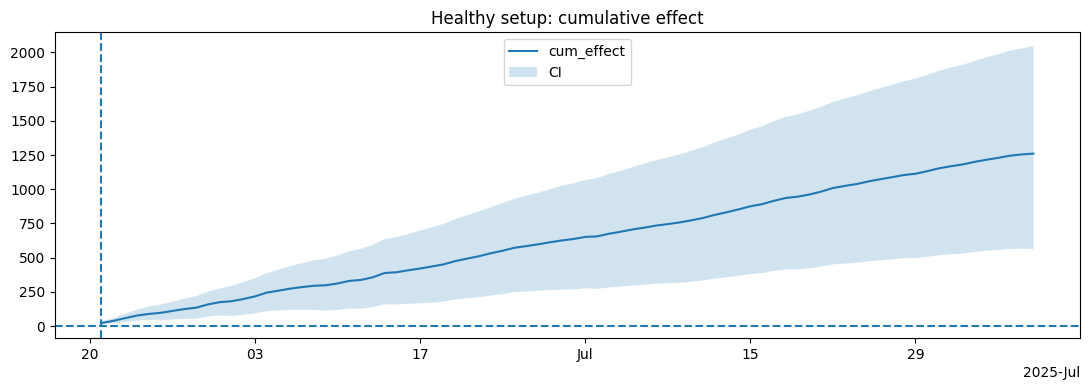

In [8]:
plot_observed_vs_counterfactual(res_good.effect_series, meta_good["intervention_date"], "Healthy setup: observed vs counterfactual")
plot_point_effect(res_good.effect_series, meta_good["intervention_date"], "Healthy setup: point effect")
plot_cum_effect(res_good.effect_series, meta_good["intervention_date"], "Healthy setup: cumulative effect")

## Failure mode 1: Weak covariates

We keep the same underlying data, but we intentionally remove key covariates from the model.

Expected symptoms:

- weaker pre-fit (lower R², higher RMSE)
- less stable / less credible effect estimate
- warnings triggered by diagnostics

In [9]:
res_weak_cov = run_ci(
    df_good,
    intervention_date=meta_good["intervention_date"],
    x_cols=[],  # intentionally drop covariates, only time trend + DOW remain
    bootstrap=250,
    run_placebo=True,
    n_placebos=30,
)
res_weak_cov.summary()

{'method': 'causal_impact_like',
 'intervention_date': '2025-05-21',
 'point_effect': 11.965830033879826,
 'point_ci': (10.025112775580714, 13.705430629923622),
 'cum_effect': 957.266402710386,
 'cum_ci': (802.0090220464572, 1096.4344503938896),
 'rel_effect': 0.06306145300837673,
 'rel_ci': (0.05283362511509578, 0.07222937039732114),
 'p_value': 0.03333333333333333,
 'warnings': [],
 'diagnostics': {'r2_pre': 0.8139071041681619,
  'rmse_pre': 10.245967235127111,
  'acf_lag1': 0.005344962535652083,
  'acf_lag2': -0.15311869688061266,
  'acf_lag3': -0.03901411705311001,
  'acf_lag4': -0.12737719506790807,
  'acf_lag5': 0.014918382174878057,
  'acf_lag6': 0.10796053509867001,
  'acf_lag7': 0.034856923442170416,
  'max_abs_acf_1_to_7': 0.15311869688061266},
 'economics': None}

In [10]:
print("Diagnostics (good):", res_good.diagnostics)
print("Diagnostics (weak covariates):", res_weak_cov.diagnostics)
print("Warnings (weak covariates):", res_weak_cov.warnings)

Diagnostics (good): {'r2_pre': 0.9608552444864409, 'rmse_pre': 4.699210051940701, 'acf_lag1': 0.04413520845664132, 'acf_lag2': -0.09422023095904274, 'acf_lag3': -0.14649324913302816, 'acf_lag4': -0.1496729017701559, 'acf_lag5': -0.09250284173790432, 'acf_lag6': 0.12253514399597334, 'acf_lag7': 0.07383902336213824, 'max_abs_acf_1_to_7': 0.1496729017701559}
Diagnostics (weak covariates): {'r2_pre': 0.8139071041681619, 'rmse_pre': 10.245967235127111, 'acf_lag1': 0.005344962535652083, 'acf_lag2': -0.15311869688061266, 'acf_lag3': -0.03901411705311001, 'acf_lag4': -0.12737719506790807, 'acf_lag5': 0.014918382174878057, 'acf_lag6': 0.10796053509867001, 'acf_lag7': 0.034856923442170416, 'max_abs_acf_1_to_7': 0.15311869688061266}
Warnings (weak covariates): []


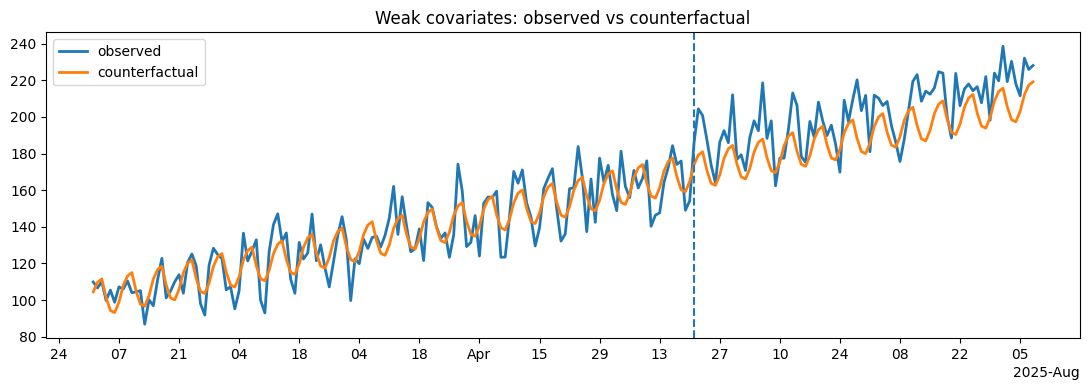

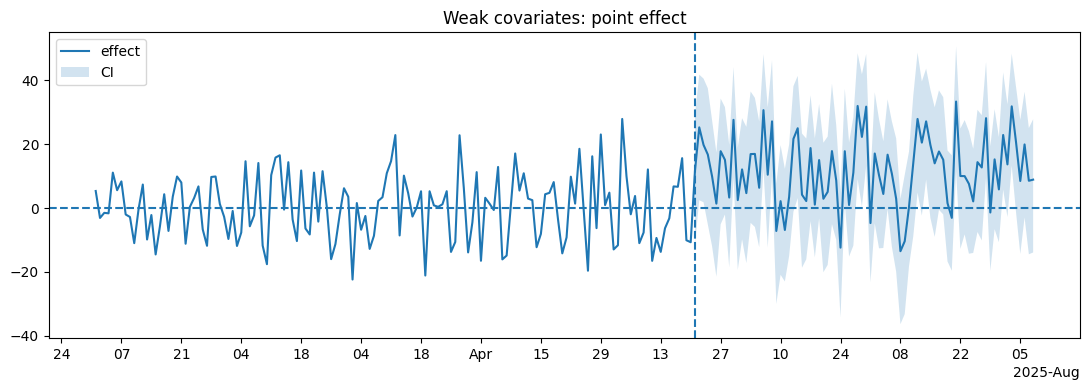

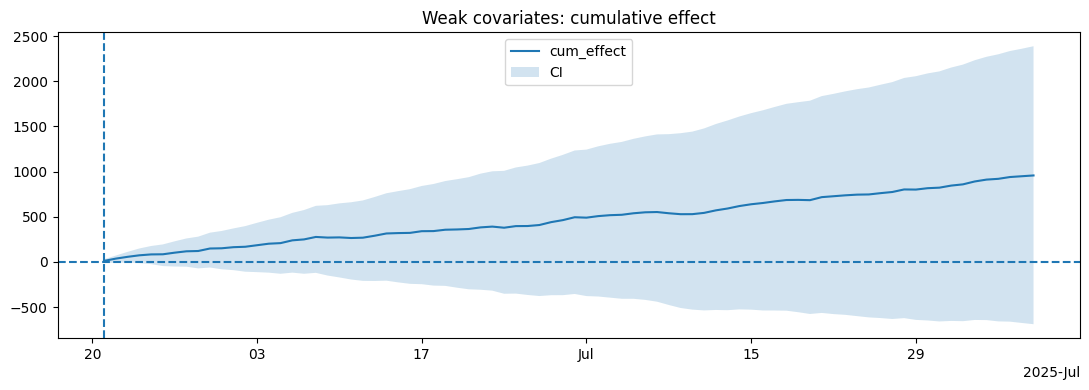

In [11]:
plot_observed_vs_counterfactual(res_weak_cov.effect_series, meta_good["intervention_date"], "Weak covariates: observed vs counterfactual")
plot_point_effect(res_weak_cov.effect_series, meta_good["intervention_date"], "Weak covariates: point effect")
plot_cum_effect(res_weak_cov.effect_series, meta_good["intervention_date"], "Weak covariates: cumulative effect")

## Failure mode 2: Confounding covariate shift

We generate a dataset with no true treatment effect, but with a covariate that shifts at the intervention date.

This is a classic confounding scenario: the model can produce an apparent 'effect' even when the true causal effect is zero.

In [12]:
cfg_confound = SyntheticTSConfig(
    n_days=220,
    start_date="2025-01-01",
    intervention_day=140,
    level_shift=0.0,         # true effect = 0
    slope_change=0.0,
    temp_effect_amp=0.0,
    confounding=True,        # covariate changes at T0
    confound_shift=120.0,
    random_state=11,
)
df_confound, meta_confound = generate_synthetic_time_series(cfg_confound)
meta_confound

{'intervention_date': '2025-05-21',
 'true_cum_effect': 0.0,
 'true_avg_effect': 0.0}

In [13]:
res_confound = run_ci(
    df_confound,
    intervention_date=meta_confound["intervention_date"],
    x_cols=["sessions", "active_users", "marketing_spend", "external_index"],
    bootstrap=250,
    run_placebo=True,
    n_placebos=30,
)
res_confound.summary()

{'method': 'causal_impact_like',
 'intervention_date': '2025-05-21',
 'point_effect': 3.132199967722164,
 'point_ci': (2.3139928986237557, 3.7881872149835893),
 'cum_effect': 250.57599741777312,
 'cum_ci': (185.11943188990043, 303.05497719868714),
 'rel_effect': 0.016488040772374767,
 'rel_ci': (0.012180962152055821, 0.019941186992432348),
 'p_value': 0.5666666666666667,
 'warnings': [],
 'diagnostics': {'r2_pre': 0.9575102532425178,
  'rmse_pre': 4.872151108052273,
  'acf_lag1': -0.12419966022127314,
  'acf_lag2': 0.0036590648705289914,
  'acf_lag3': -0.0767539572834028,
  'acf_lag4': -0.08493644651568867,
  'acf_lag5': 0.07325001066367264,
  'acf_lag6': -0.2250975529743858,
  'acf_lag7': 0.1770952936017373,
  'max_abs_acf_1_to_7': 0.2250975529743858},
 'economics': None}

In [14]:
print("True cumulative effect (synthetic):", meta_confound.get("true_cum_effect"))
print("Estimated cumulative effect:", res_confound.cum_effect)
print("CI:", res_confound.cum_ci)
print("Placebo p-value:", res_confound.p_value)
print("Warnings:", res_confound.warnings)

True cumulative effect (synthetic): 0.0
Estimated cumulative effect: 250.57599741777312
CI: (185.11943188990043, 303.05497719868714)
Placebo p-value: 0.5666666666666667
Warnings: []


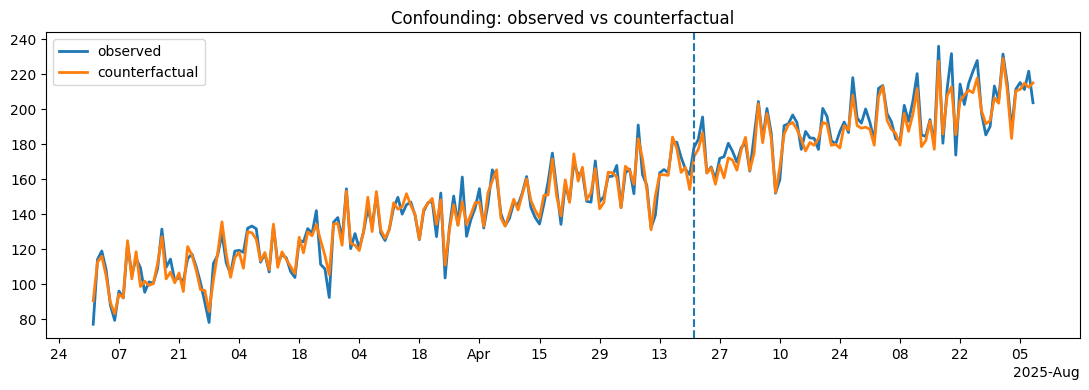

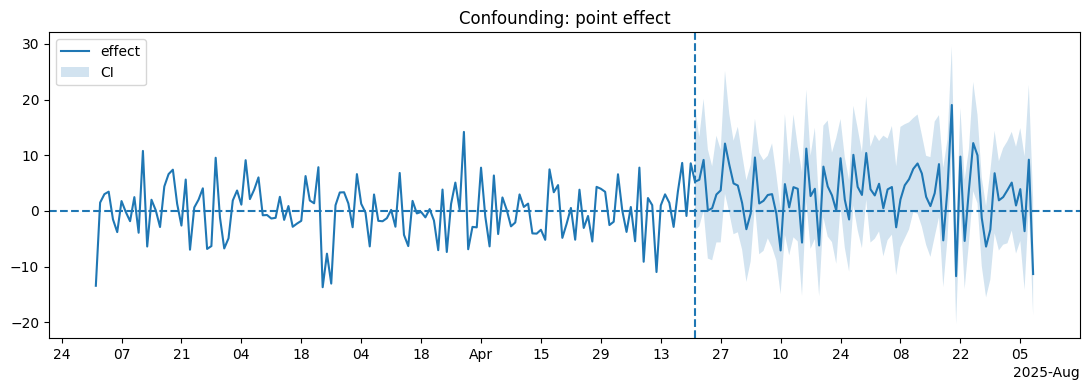

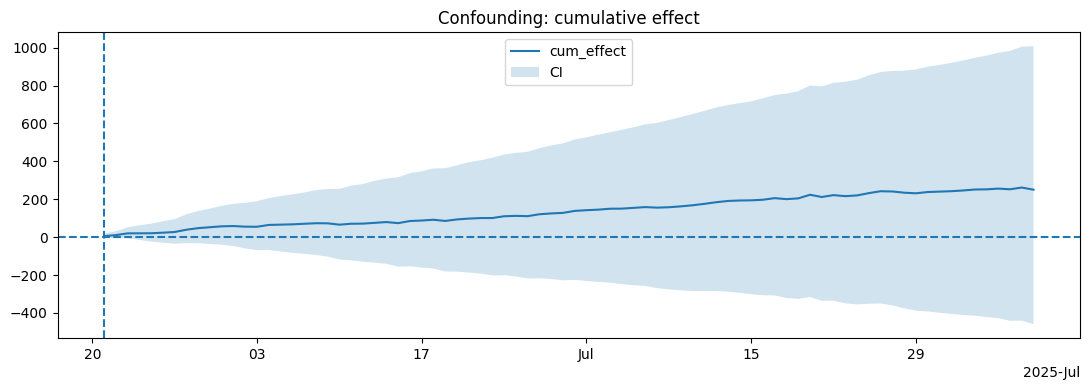

In [15]:
plot_observed_vs_counterfactual(res_confound.effect_series, meta_confound["intervention_date"], "Confounding: observed vs counterfactual")
plot_point_effect(res_confound.effect_series, meta_confound["intervention_date"], "Confounding: point effect")
plot_cum_effect(res_confound.effect_series, meta_confound["intervention_date"], "Confounding: cumulative effect")

### Inspect covariate break at intervention

A practical guardrail: plot key covariates and check for structural breaks at the intervention date.

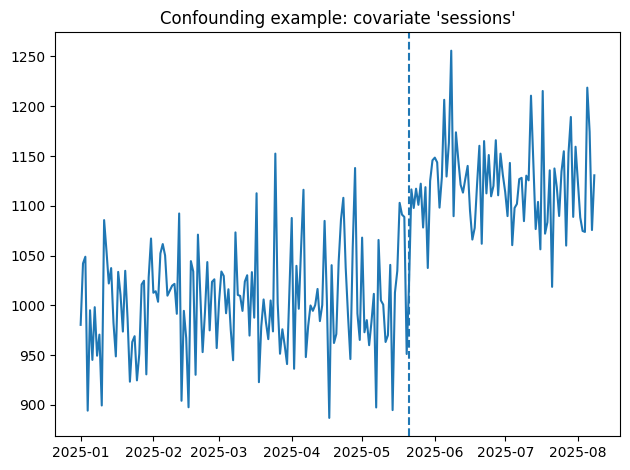

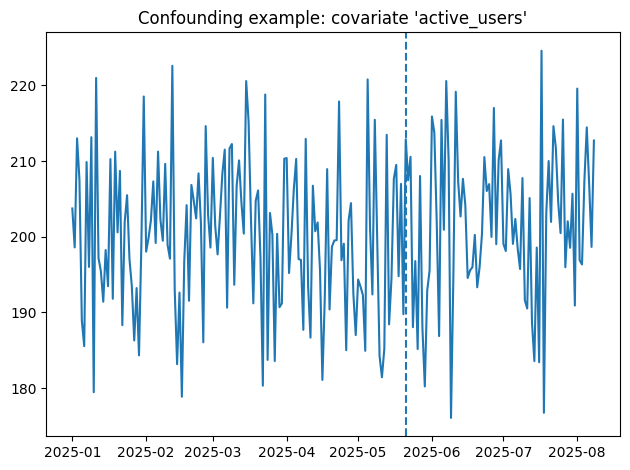

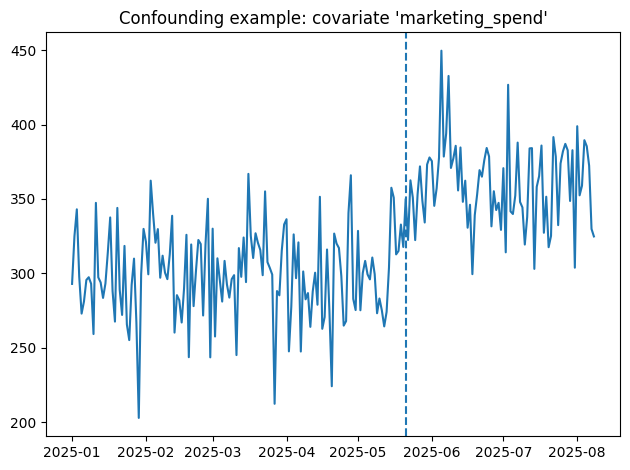

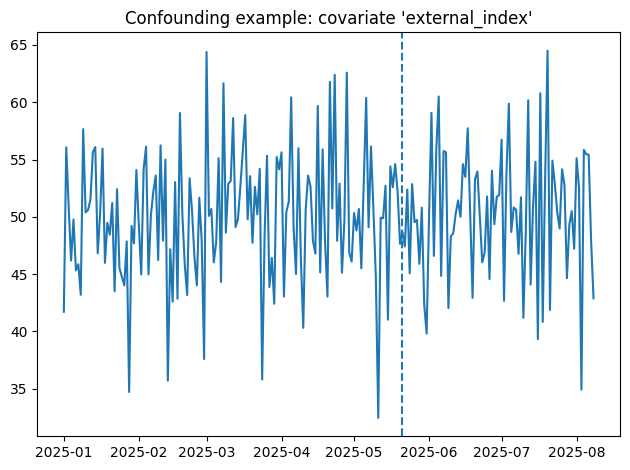

In [16]:
d = df_confound.copy()
d["date"] = pd.to_datetime(d["date"])
for c in ["sessions", "active_users", "marketing_spend", "external_index"]:
    if c not in d.columns:
        continue
    plt.figure()
    plt.plot(d["date"], d[c])
    plt.axvline(pd.Timestamp(meta_confound["intervention_date"]), linestyle="--")
    plt.title(f"Confounding example: covariate '{c}'")
    plt.tight_layout()
    plt.show()

## Failure mode 3: Short pre-period

We take the healthy dataset but truncate history so the pre-period is short.

Expected symptoms:

- unstable fit
- wider uncertainty
- less reliable placebo inference

In [17]:
# Truncate to keep only ~35 pre days before intervention + post days
intervention_ts = pd.Timestamp(meta_good["intervention_date"])
df_short_pre = df_good.copy()
df_short_pre["date"] = pd.to_datetime(df_short_pre["date"])
start = intervention_ts - pd.Timedelta(days=35)
df_short_pre = df_short_pre[(df_short_pre["date"] >= start)].copy()
df_short_pre["date"] = df_short_pre["date"].dt.strftime("%Y-%m-%d")

df_short_pre.head(), df_short_pre.shape

(           date           y     sessions  active_users  marketing_spend  \
 105  2025-04-16  160.908618  1063.318372    206.455351       303.850944   
 106  2025-04-17  166.562942   932.765386    198.353092       300.078437   
 107  2025-04-18  171.755253  1004.489380    201.788235       334.542009   
 108  2025-04-19  149.992531   977.586945    193.123254       274.862916   
 109  2025-04-20  132.198743  1003.929869    179.873781       282.162715   
 
      external_index  
 105       57.706151  
 106       58.003492  
 107       54.699904  
 108       46.444584  
 109       43.902927  ,
 (115, 6))

In [18]:
# Use a smaller pre_period_min_points to allow the run, so we can see the instability
spec_short = DataSpec(
    date_col="date",
    y_col="y",
    x_cols=["sessions", "active_users", "marketing_spend", "external_index"],
    freq="D",
    add_time_trend=True,
    add_day_of_week=True,
)

cfg_short = ImpactConfig(
    intervention_date=meta_good["intervention_date"],
    method=ImpactMethod.CAUSAL_IMPACT_LIKE,
    ridge_alpha=1.0,
    bootstrap_iters=250,
    block_size=7,
    alpha=0.05,
    run_placebo=True,
    n_placebos=25,
    pre_period_min_points=20,
)

res_short_pre = run_impact(df_short_pre, spec_short, cfg_short)
res_short_pre.summary()

{'method': 'causal_impact_like',
 'intervention_date': '2025-05-21',
 'point_effect': 20.04513110387692,
 'point_ci': (19.278414279736737, 20.624439308288487),
 'cum_effect': 1603.6104883101536,
 'cum_ci': (1542.273142378939, 1649.955144663079),
 'rel_effect': 0.11033849915193107,
 'rel_ci': (0.10611810352509474, 0.1135273033303587),
 'p_value': None,
 'warnings': [],
 'diagnostics': {'r2_pre': 0.8890422543272837,
  'rmse_pre': 4.601065043146477,
  'acf_lag1': 0.07668985937892579,
  'acf_lag2': -0.20588197462135624,
  'acf_lag3': -0.14434959375285444,
  'acf_lag4': -0.2771738979320582,
  'acf_lag5': -0.3437405089393585,
  'acf_lag6': 0.19835977281058936,
  'acf_lag7': 0.1485806161197796,
  'max_abs_acf_1_to_7': 0.3437405089393585},
 'economics': None}

In [20]:
print("Diagnostics (healthy):", res_good.diagnostics)
print("Diagnostics (short pre):", res_short_pre.diagnostics)
print("Warnings (short pre):", res_short_pre.warnings)

Diagnostics (healthy): {'r2_pre': 0.9608552444864409, 'rmse_pre': 4.699210051940701, 'acf_lag1': 0.04413520845664132, 'acf_lag2': -0.09422023095904274, 'acf_lag3': -0.14649324913302816, 'acf_lag4': -0.1496729017701559, 'acf_lag5': -0.09250284173790432, 'acf_lag6': 0.12253514399597334, 'acf_lag7': 0.07383902336213824, 'max_abs_acf_1_to_7': 0.1496729017701559}
Diagnostics (short pre): {'r2_pre': 0.8890422543272837, 'rmse_pre': 4.601065043146477, 'acf_lag1': 0.07668985937892579, 'acf_lag2': -0.20588197462135624, 'acf_lag3': -0.14434959375285444, 'acf_lag4': -0.2771738979320582, 'acf_lag5': -0.3437405089393585, 'acf_lag6': 0.19835977281058936, 'acf_lag7': 0.1485806161197796, 'max_abs_acf_1_to_7': 0.3437405089393585}
Warnings (short pre): []


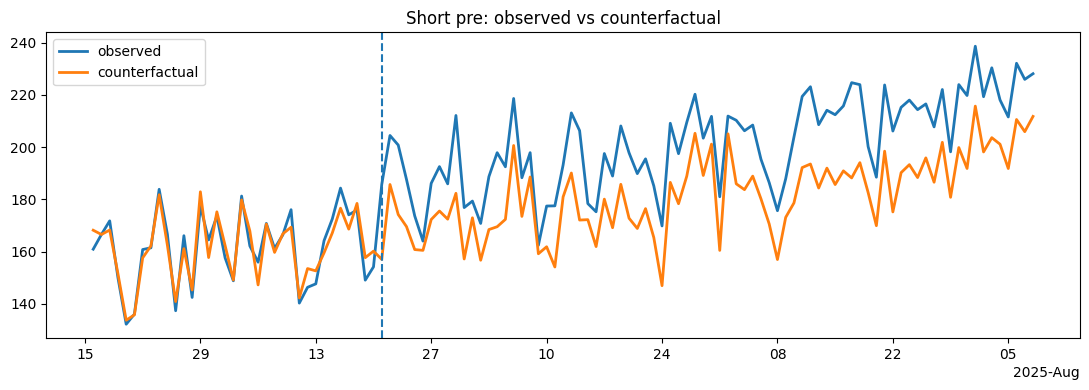

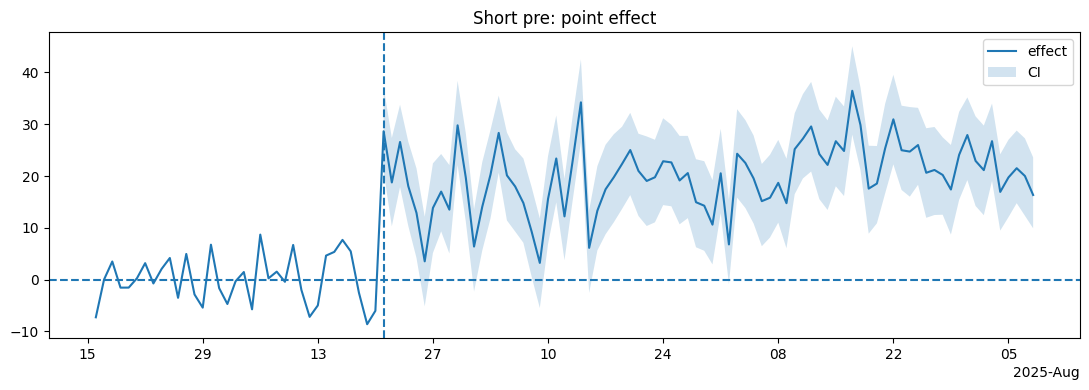

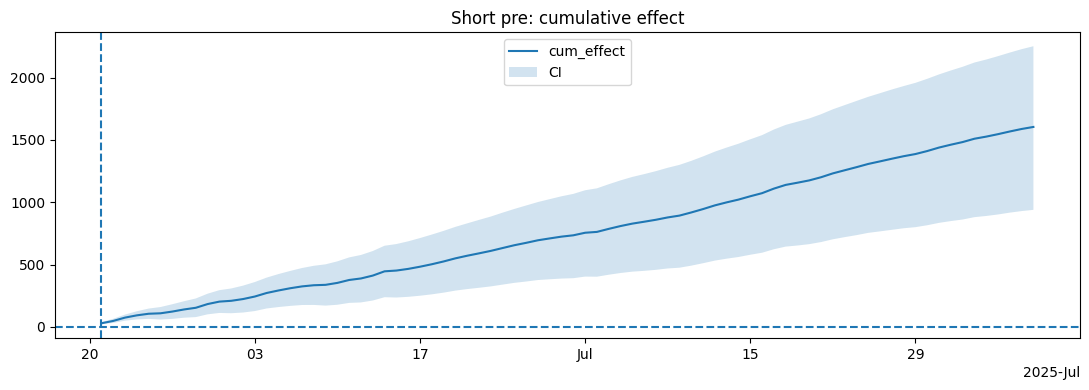

In [21]:
plot_observed_vs_counterfactual(res_short_pre.effect_series, meta_good["intervention_date"], "Short pre: observed vs counterfactual")
plot_point_effect(res_short_pre.effect_series, meta_good["intervention_date"], "Short pre: point effect")
plot_cum_effect(res_short_pre.effect_series, meta_good["intervention_date"], "Short pre: cumulative effect")

## Summary: how to detect when NOT to trust the estimate

Use the built-in guardrails:

Pre-fit quality (R², RMSE). Weak fit → counterfactual is unreliable.
- Residual autocorrelation warnings.
- Placebo-in-time: if your effect is common under fake dates, do not trust it.
- Covariate break checks: if key controls shift at intervention, confounding is likely.
- Sensitivity tests: if results change drastically when you drop one covariate or shorten pre, treat the estimate as fragile.